In [ ]:
import preprocess

In [ ]:
tst = [2020, 9, 5, "AM"]
ted =  [2020, 9, 8, "AM"]
region = ('CreekSNPPPreprocess', [-119.5, 36.8, -118.9, 37.7])

In [ ]:
import FireTime

list_of_ts = list(FireTime.t_generator(tst, ted))
list_of_ts

In [ ]:
!ls -lah ./tests/data/processed

## Once per landcover file

If your landcover file is not in lat,lon then transform it and resave it. You will use this file a bunch later on.

In [ ]:
preprocess.preprocess_landcover()

## Once per region

Preprocess the region to get rid of static flare sources. Save that new "swiss cheese" shape off into a geojson file for later.

In [ ]:
preprocess.preprocess_region(region)

In [ ]:
!ls -lah ./tests/data/processed/VIIRS/CreekSNPPPreprocess/

## Once per input file

Next process each NRT file into half day files. First we'll get all the times that are of interest. This could also be done by inspecting all looking at all the files that exist and seeing which have not been preprocessed yet.

In [ ]:
# %%time
# NOTE: BigCreek doesn't have NRT files so we have to use monthly
# for sat in ["SNPP", "NOAA20"]:
#     for t in list_of_ts[::2]:
#         preprocess.preprocess_NRT_file(t, sat)

In [ ]:
%%time
for sat in ["SNPP"]:
    for t in list_of_ts[::2]:
        preprocess.preprocess_monthly_file(t, sat)

In [ ]:
!ls -lah ./tests/data/processed/SNPP/

## Once per region and t

Do initial filtering and clustering using the preprocessed region and the half day files.

Note: for the purpose of timing I am running the full month, but each of these steps could run in a separate proccess.

In [ ]:
region = preprocess.read_region(region)

In [ ]:
# import FireIO, folium
# region_shp = FireIO.get_reg_shp(region[1])
# df = preprocess.read_preprocessed([2020, 9, 6, 'PM'], sat="SNPP")
# min_lat, max_lat = df['Lat'].min(), df['Lat'].max()
# min_lon, max_lon = df['Lon'].min(), df['Lon'].max()
# df_shp = FireIO.get_reg_shp([min_lon, min_lat, max_lon, max_lat])
# mymap = folium.Map(zoom_start=7)

# folium.GeoJson(df_shp, 
#                style_function=lambda x: {'fillColor': 'pink', 'color': 'red', 'weight': 2}).add_to(mymap)

# for index, row in df.iterrows():
#     folium.CircleMarker(location=[row['Lat'], row['Lon']],
#                         radius=1,  # Define the circle size
#                         color='red',
#                         fill=True,
#                         fill_color='red',
#                         fill_opacity=0.6).add_to(mymap)

# folium.GeoJson(region_shp, 
#                style_function=lambda x: {'color': 'cyan', 'weight': 2}).add_to(mymap)
# mymap

In [ ]:
%%time
timestep_skips = []
for t in list_of_ts:
    outfile_path = preprocess.preprocess_region_t(t, sat="SNPP", region=region)
    # if outfile_path is None then there were no fire pixels so we need to skip this timestep in later processing
    if outfile_path is None:
        timestep_skips.append(t)
timestep_skips

In [ ]:
!ls -lah ./tests/data/processed/VIIRS/CreekSNPPPreprocess

## Use FireRun test

In [ ]:
from FireRun import ProcessNRT

allfires_tuple = ProcessNRT(region[0], tst, ted, timestep_skips)
allfires = allfires_tuple[0]

In [ ]:
allfires

## Find a big fire

In [ ]:
{fid: fire.n_pixels for fid, fire in allfires.fires.items() if fire.n_pixels > 1000}

In [15]:
allfires.fires[1].pixels

,Lat,Lon,FRP,Sat,DT,DS,YYYYMMDD_HHMM,ampm,x,y,initial_cid,t,fid,in_fline
uuid,,,,,,,,,,,,,,
40a52a22-3124-4a1e-9d23-f55d3923bfb7,37.201797,-119.271812,21.04,SNPP,0.442377,0.385693,2020-09-05 10:00:00,AM,-1.692131e+06,-670256.379954,0,2020-09-05,1,True
1a854aa0-2338-40a0-a4ed-551502e0d263,37.199169,-119.277367,4.98,SNPP,0.442199,0.385621,2020-09-05 10:00:00,AM,-1.692670e+06,-670430.137837,0,2020-09-05,1,True
6a5caba4-8db1-40c9-a5db-397ca3a1d85f,37.198254,-119.272469,21.04,SNPP,0.442377,0.385693,2020-09-05 10:00:00,AM,-1.692271e+06,-670629.547556,0,2020-09-05,1,None
1d463919-5e3a-4e49-9744-3a2d7e31f556,37.197338,-119.267548,21.04,SNPP,0.442556,0.385766,2020-09-05 10:00:00,AM,-1.691870e+06,-670829.510435,0,2020-09-05,1,True
dd9e0587-4f2a-4903-a77f-95baf59f6088,37.195644,-119.278160,44.95,SNPP,0.442199,0.385621,2020-09-05 10:00:00,AM,-1.692822e+06,-670798.568062,0,2020-09-05,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1fe029f9-7eb7-4d95-ad24-1a66a6e21937,37.013283,-119.281837,12.27,SNPP,0.520021,0.668137,2020-09-08 10:42:00,AM,-1.697441e+06,-690618.151198,21,2020-09-08,1,None
7bdb5e01-fedf-40a6-9ee0-611eb7450b04,37.010933,-119.273651,2.98,SNPP,0.520420,0.668340,2020-09-08 10:42:00,AM,-1.696792e+06,-691041.281859,21,2020-09-08,1,True
2b5c6282-502d-4d0b-ba6c-5a9f0e75cf99,37.028984,-119.359322,6.00,SNPP,0.514503,0.665318,2020-09-08 10:42:00,AM,-1.703740e+06,-687323.573372,21,2020-09-08,1,None


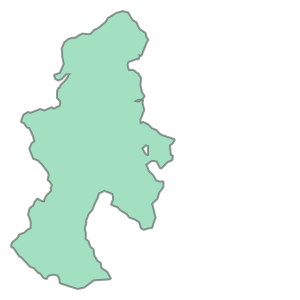

In [16]:
allfires.fires[1].hull

In [17]:
import folium
from pyproj import Transformer
from shapely.ops import transform


transformer = Transformer.from_crs("EPSG:9311", "EPSG:4326", always_xy=True)
transformed_polygon = transform(transformer.transform, allfires.fires[1].hull)

mymap = folium.Map(zoom_start=7)
folium.GeoJson(transformed_polygon.__geo_interface__, 
               style_function=lambda x: {'fillColor': 'pink', 'color': 'red', 'weight': 4}).add_to(mymap)
mymap